# Remarks

* Data normalization
    * Mobilenet expects data from -1 to 1
        * Normalize Input Data or Include in Model
        * TFLite Conversion must fit according to decision
    * Ground Truth Data: for better inspection Data multiplied by 80. Undo the change in the Data Input Pipeline
* Overview in Tutorials:
    * tf.function
    * Repeat addapted Version of using Build in methods for training, ...
    * Save models using keras
        * CaseNet first real model: check in implementation of Frey if a Layer needs to be written
        * other Example: depth seperable dilated convolution,
* Idea
    * Loss
        * Focal Loss: for imbalanced Data
        * In general Loss: just now weight in each dependent on number of Edge Pixels

# Libraries

TODO:
- Result better if "Fine Tuning" -> whole backbone frozen ?
- plot and compute results before and after training of the following:
- Metrics: widen and not of F1 for
    - test
    - test_advanced
- Images of the following
    - test
    - test_advanced
    - random more advanced and difficult (no GT)

In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
#import sys
import matplotlib.pyplot as plt
import argparse

import DataProcessing.data_processing as data_processing
import Nets.backbones as backbones
import Nets.features as features
import Nets.losses as losses
import Nets.metrics as metrics
import Nets.visualize as visualize


os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#np.set_printoptions(threshold=sys.maxsize)

# Parser

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--model', type=str, required=False, default=None)
parser.add_argument('--model_loaded', type=str, required=False, default=None)
parser.add_argument('--data', type=str, required=False, default=None)
parser.add_argument('--data_base_model', type=str, required=False, default=None)

parser.add_argument('--bs', type=int, required=False, default=None)
parser.add_argument('--idx', type=int, required=False, default=None)
parser.add_argument('--epoch', type=int, required=False, default=None)

parser.add_argument('--train_model', action='store_true', default=False)
parser.add_argument('--cache', action='store_true', default=False)
parser.add_argument('--save', action='store_true', default=False)
parser.add_argument('--sigmoid', action='store_true', default=False)
parser.add_argument('--focal', action='store_true', default=False)

parser.add_argument('--beta_upper', type=float, required=False, default=None)
parser.add_argument('--gamma', type=float, required=False, default=None)
parser.add_argument('--alpha', type=float, required=False, default=None)

file_name = None
try:
    file_name = __file__
except:
    print("Jupyter Notebook")
       
if file_name is None:
    args = parser.parse_args("")
    args.train_model = False
    args.cache = True
    args.save = True
    args.sigmoid = False
    args.focal = True
else:    
    args = parser.parse_args()

Jupyter Notebook


# Options

In [3]:
# Generall Parameters
MODEL= 'CASENET_FOCAL_LOSS_0.5_g2_a2_real' if args.model is None else args.model
MODEL_LOADED = 'CASENET_FOCAL_LOSS_0.5_g2_a2' if args.model_loaded is None else args.model_loaded
DATA = 'RealRed' if args.data is None else args.data
DATA_BASE_MODEL_LOADED = 'SceneNetFloorTiledTextureIMG' if args.data_base_model is None else args.data_base_model
TRAIN_DS = 'Train'
TEST_DS = 'Test'
TEST_HARD_DS = 'Test Hard'
TEST_IMG_DS = 'Test IMG'
HALF = True

# Dataset Loading Parameters
IMG_SIZE_HEIGHT = 1280
IMG_SIZE_WIDTH = 720
NUM_CLASSES = 3
MAX_IMG_TRAIN = 100
MAX_IMG_TEST = 25
SEED = None
BATCH_SIZE = 3 if args.bs is None else args.bs
CACHE = args.cache


# Model Parameters
TRAINABLE_IDX = 2 if args.idx is None else args.idx # (3-1), as indexing starts at 0
EPOCHS = 30 if args.epoch is None else args.epoch
SAVE = args.save
TRAIN_MODEL = args.train_model

#Model Callback
MODEL_SAVE_EPOCH_FREQ = 5
DEL_OLD_CHECKPOINTS = False
TENSORBOARD = False
DEL_OLD_TENSORBOARD = True

# LOSS
weighted_multi_label_sigmoid_edge_loss = args.sigmoid
focal_loss = args.focal

beta_upper = 0.5 if args.beta_upper is None else args.beta_upper
beta_lower = 1.0 - beta_upper
gamma=2.0 if args.gamma is None else args.gamma 
alpha=2.0 if args.alpha is None else args.alpha
class_weighted = True
weighted_beta=True

THRESHOLD_EDGE_WIDTH_REAL = 3

#TESTING
test = False
if test:
    EPOCHS = 10
    MAX_IMG_TRAIN = 100
    MAX_IMG_TEST = 10

# Load Dataset, Preprocess Images and Dataset

In [4]:
tf.random.set_seed(SEED)

paths, files = data_processing.path_definitions(HALF, MODEL, DATA, TRAIN_DS, TEST_DS, TEST_HARD_DS, TEST_IMG_DS, 
                                                MODEL_LOADED, DATA_BASE_MODEL_LOADED, make_dirs=True)

data_processing.clean_model_directories(paths, DEL_OLD_CHECKPOINTS, DEL_OLD_TENSORBOARD)

train_ds, img_count_train = data_processing.load_dataset(paths,"TRAIN", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TRAIN)
train_ds = data_processing.dataset_processing(train_ds, cache=CACHE, shuffle=True, batch_size=BATCH_SIZE, 
                                              prefetch=True, img_count=img_count_train, augment=True)

test_ds, img_count_test = data_processing.load_dataset(paths,"TEST", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST)
test_ds = data_processing.dataset_processing(test_ds, cache=CACHE, shuffle=False, batch_size=BATCH_SIZE, 
                                             prefetch=True, img_count=img_count_test, augment=False)

test_hard_ds, img_count_test_hard = data_processing.load_dataset(paths,"TEST_HARD", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST)
test_hard_ds = data_processing.dataset_processing(test_hard_ds, cache=False, shuffle=False, batch_size=BATCH_SIZE,
                                                  prefetch=False, img_count=img_count_test_hard, augment=False)

test_img_ds, img_count_test_img = data_processing.load_dataset(paths,"IMG_ONLY", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST, has_mask=False)
test_img_ds = data_processing.dataset_processing(test_img_ds, cache=False, shuffle=False, batch_size=BATCH_SIZE, 
                                                 prefetch=False, img_count=img_count_test_img, augment=False)

2022-05-15 15:24:29.570067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 15:24:29.581566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 15:24:29.581746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 15:24:29.582470: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

The TRAIN Dataset contains 87 images.


TypeError: in user code:


    TypeError: tf__augment_mapping() takes 1 positional argument but 2 were given


# Model

In [5]:
if weighted_multi_label_sigmoid_edge_loss:
    loss = lambda y_true, y_pred : losses.weighted_multi_label_sigmoid_loss(y_true,y_pred,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
elif focal_loss:
    loss = lambda y_true, y_pred : losses.focal_loss_edges(y_true, y_pred, gamma=gamma, alpha=alpha, weighted_beta=weighted_beta,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
else:
    raise ValueError("either FocalLoss or WeightedMultiLabelSigmoidLoss must be True")
    

custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges,
                  "F1Edges": metrics.F1Edges,
                  "<lambda>":loss}

model = tf.keras.models.load_model(paths["MODEL LOADED"], custom_objects=custom_objects)

# Visual Results before Fine Tuning on Real World Data

## test dataset

2022-05-15 14:39:55.842458: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-05-15 14:39:56.832939: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


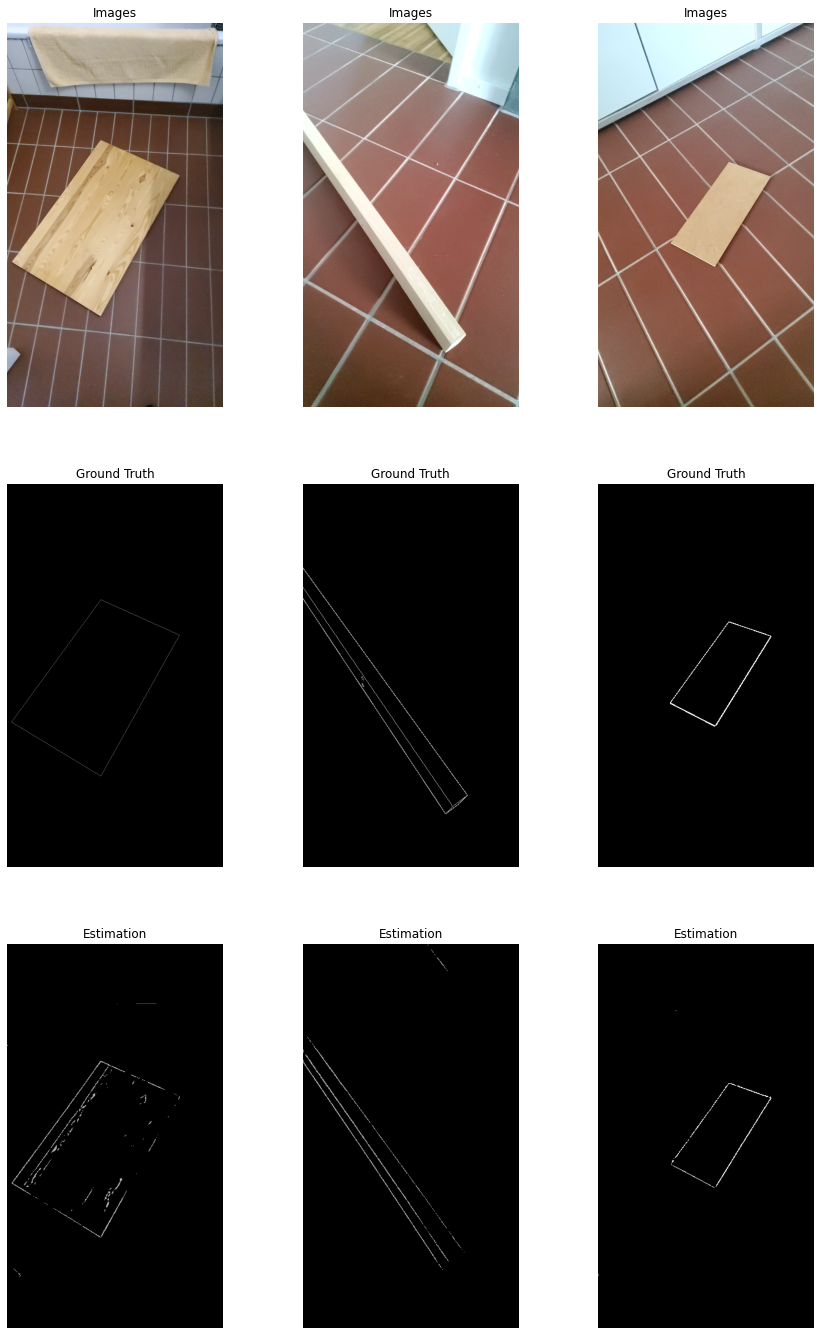

In [6]:
for img, label in test_ds.take(1):
    img, label = img, label

predictions = model.predict(img)    
predictions = visualize.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"pre_training_images_test")
visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)

## test hard

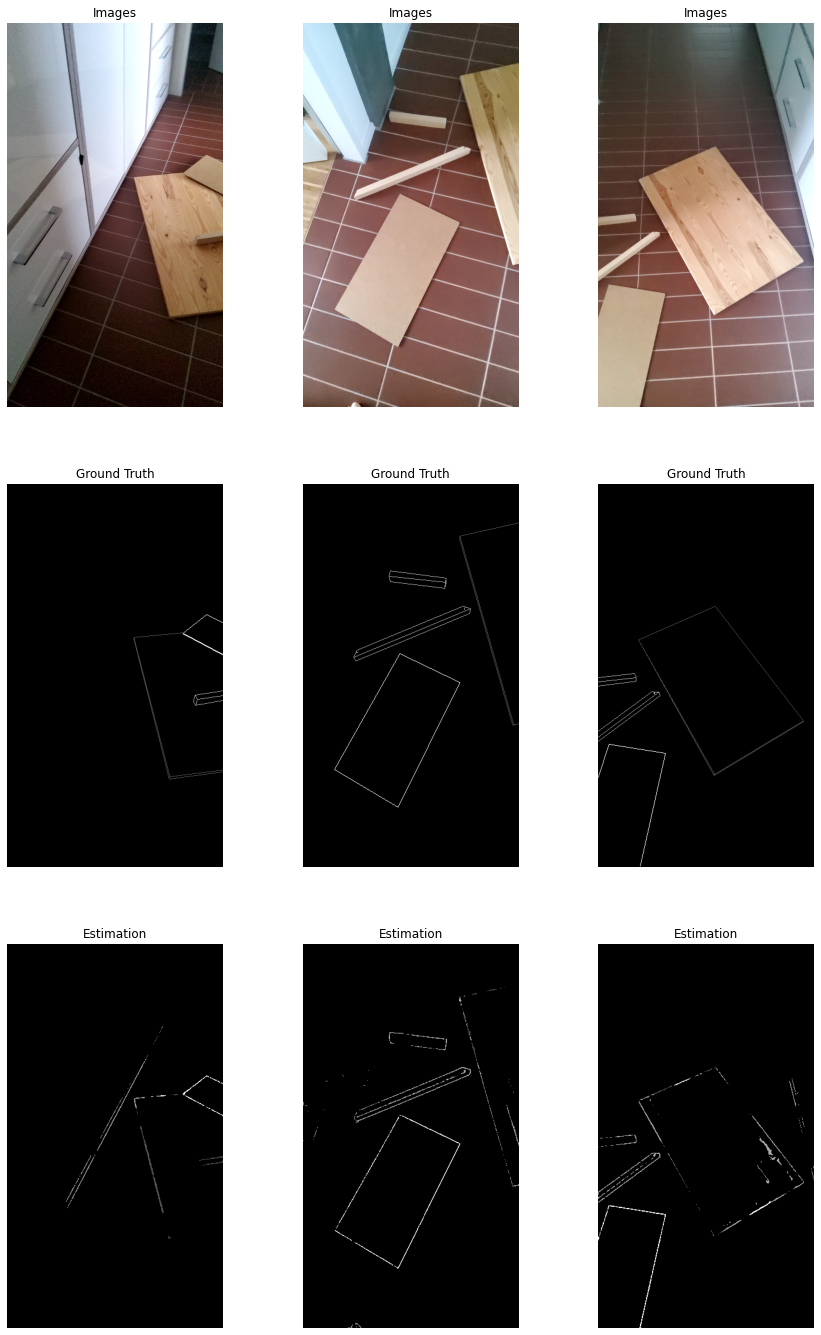

In [7]:
for img, label in test_hard_ds.take(1):
    img, label = img, label

predictions = model.predict(img)    
predictions = visualize.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"pre_training_images_test_hard")
visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)

## test img

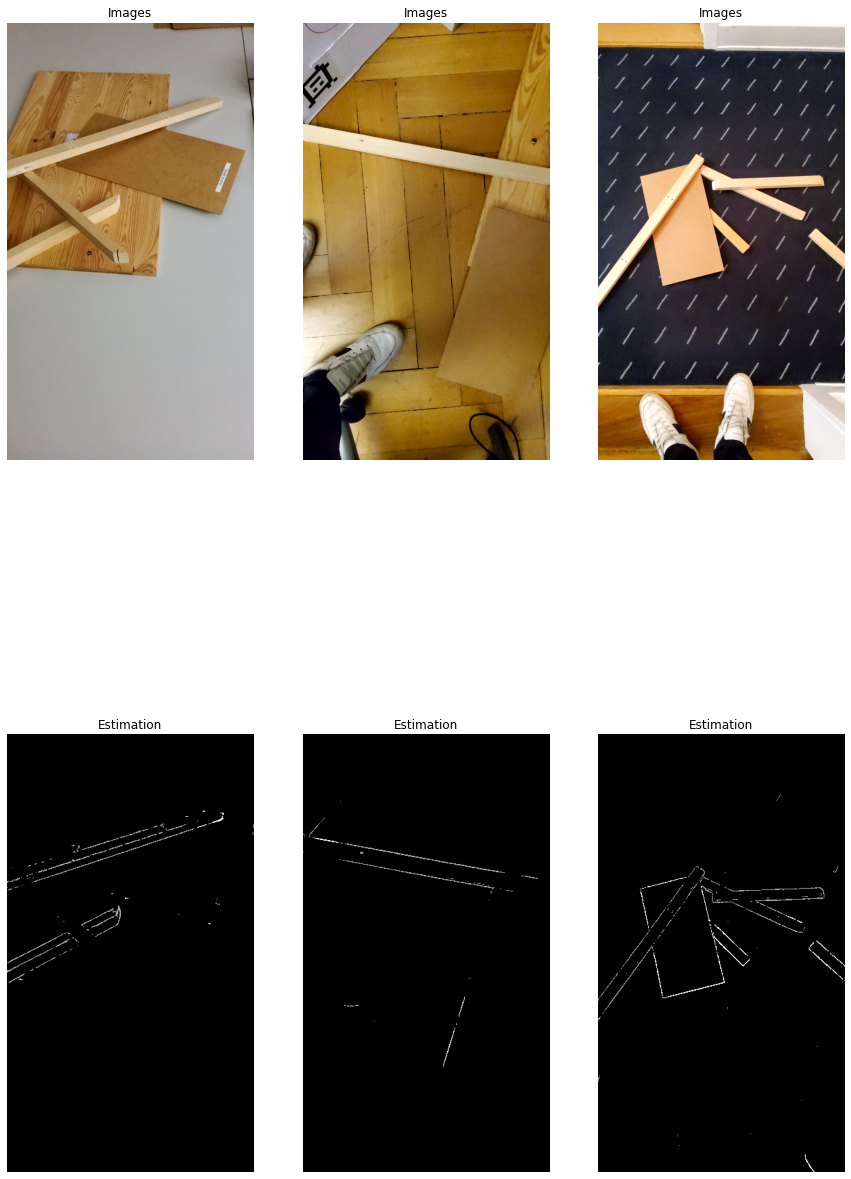

In [8]:
for img in test_img_ds.take(1):
    img = img

predictions = model.predict(img)    
predictions = visualize.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"pre_training_images_test_img")
try:
    visualize.plot_images(images=img, labels=None, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)
except:
    visualize.plot_images(images=img, labels=None, predictions=predictions, save=SAVE, path=path, batch_size=img_count_test_img)

# Metric Numerical Results before Fine Tuning on Real World Data

## test

## test hard

# Compile and Train Model

In [9]:
if TENSORBOARD:
    %load_ext tensorboard
    %tensorboard --logdir /home/david/SemesterProject/Models/CASENet/logs

In [10]:
# Fine-tune from this layer onwards
output_names = ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block23_out", "conv5_block3_out"]
fine_tune_output = output_names[TRAINABLE_IDX]

model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer: 
for submodel in model.layers:
    if submodel.name == "base_model":
        for layer in submodel.layers:
            layer.trainable = False
            if layer.name == fine_tune_output:
                break


# learning rate schedule
base_learning_rate = 0.0005
end_learning_rate = 0.0001
decay_step = np.ceil(img_count_train / BATCH_SIZE)*EPOCHS
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(base_learning_rate,decay_steps = decay_step,end_learning_rate = end_learning_rate, power = 0.9)

frequency = int(np.ceil(img_count_train / BATCH_SIZE)*MODEL_SAVE_EPOCH_FREQ)

logdir = os.path.join(paths['TBLOGS'], datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = paths["CKPT"]+ "/ckpt-loss={loss:.2f}-epoch={epoch:.2f}",save_weights_only=False,save_best_only=False,monitor="val_loss",verbose=1,save_freq= frequency),
            tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)]

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=loss,
              metrics={'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                  metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds, callbacks=callbacks)

Epoch 1/30
29/29 [==============================] - 18s 470ms/step - loss: 1095.0950 - output_loss: 593.5932 - side5_loss: 501.5018 - output_accuracy_edges: 0.9949 - f1: 0.3513 - precision: 0.3583 - recall: 0.3460 - val_loss: 504.8340 - val_output_loss: 270.2732 - val_side5_loss: 234.5608 - val_output_accuracy_edges: 0.9964 - val_f1: 0.5250 - val_precision: 0.5022 - val_recall: 0.5499
Epoch 2/30
29/29 [==============================] - 12s 425ms/step - loss: 484.3605 - output_loss: 265.4496 - side5_loss: 218.9110 - output_accuracy_edges: 0.9958 - f1: 0.4976 - precision: 0.5432 - recall: 0.4604 - val_loss: 452.1061 - val_output_loss: 242.1733 - val_side5_loss: 209.9329 - val_output_accuracy_edges: 0.9966 - val_f1: 0.5476 - val_precision: 0.5343 - val_recall: 0.5615
Epoch 3/30
29/29 [==============================] - 12s 424ms/step - loss: 407.6462 - output_loss: 220.7534 - side5_loss: 186.8928 - output_accuracy_edges: 0.9962 - f1: 0.5484 - precision: 0.5916 - recall: 0.5113 - val_loss: 

2022-05-15 14:41:12.899306: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/SceneNetFloorTiledTextureIMG/CASENET_FOCAL_LOSS_0.5_g2_a2_real/CKPT/ckpt-loss=353.36-epoch=5.00/assets
29/29 [==============================] - 23s 813ms/step - loss: 353.3570 - output_loss: 189.7991 - side5_loss: 163.5579 - output_accuracy_edges: 0.9964 - f1: 0.5892 - precision: 0.6237 - recall: 0.5587 - val_loss: 355.3630 - val_output_loss: 192.8037 - val_side5_loss: 162.5592 - val_output_accuracy_edges: 0.9970 - val_f1: 0.5747 - val_precision: 0.6032 - val_recall: 0.5487
Epoch 6/30
29/29 [==============================] - 12s 425ms/step - loss: 338.7277 - output_loss: 181.9964 - side5_loss: 156.7312 - output_accuracy_edges: 0.9965 - f1: 0.6161 - precision: 0.6466 - recall: 0.5890 - val_loss: 351.3811 - val_output_loss: 189.5879 - val_side5_loss: 161.7932 - val_output_accuracy_edges: 0.9970 - val_f1: 0.5954 - val_precision: 0.5993 - val_recall: 0.5915
Epoch 7/30
29/29 [==============================] - 12s 428ms/st

Epoch 22/30
29/29 [==============================] - 12s 426ms/step - loss: 201.6178 - output_loss: 101.0512 - side5_loss: 100.5666 - output_accuracy_edges: 0.9978 - f1: 0.7660 - precision: 0.7700 - recall: 0.7624 - val_loss: 397.5570 - val_output_loss: 203.3124 - val_side5_loss: 194.2447 - val_output_accuracy_edges: 0.9972 - val_f1: 0.6163 - val_precision: 0.6432 - val_recall: 0.5915
Epoch 23/30
29/29 [==============================] - 12s 424ms/step - loss: 195.2397 - output_loss: 97.8804 - side5_loss: 97.3594 - output_accuracy_edges: 0.9979 - f1: 0.7621 - precision: 0.7874 - recall: 0.7386 - val_loss: 415.7850 - val_output_loss: 211.0629 - val_side5_loss: 204.7221 - val_output_accuracy_edges: 0.9972 - val_f1: 0.6098 - val_precision: 0.6521 - val_recall: 0.5727
Epoch 24/30
29/29 [==============================] - 12s 427ms/step - loss: 189.4984 - output_loss: 94.6601 - side5_loss: 94.8383 - output_accuracy_edges: 0.9979 - f1: 0.7748 - precision: 0.7879 - recall: 0.7621 - val_loss: 41

# training evolution

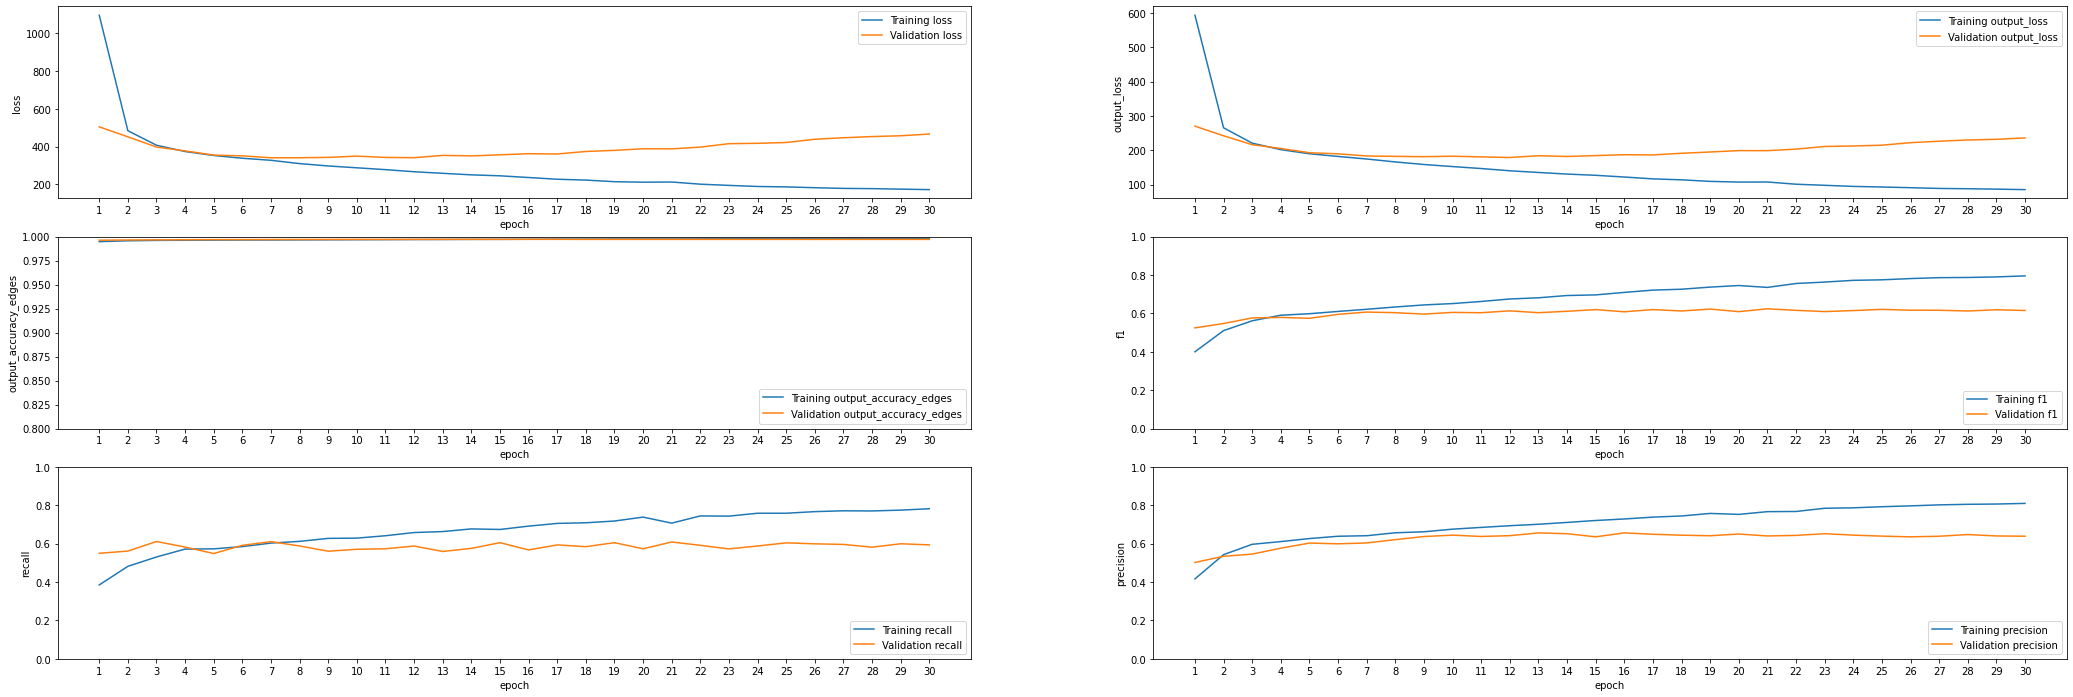

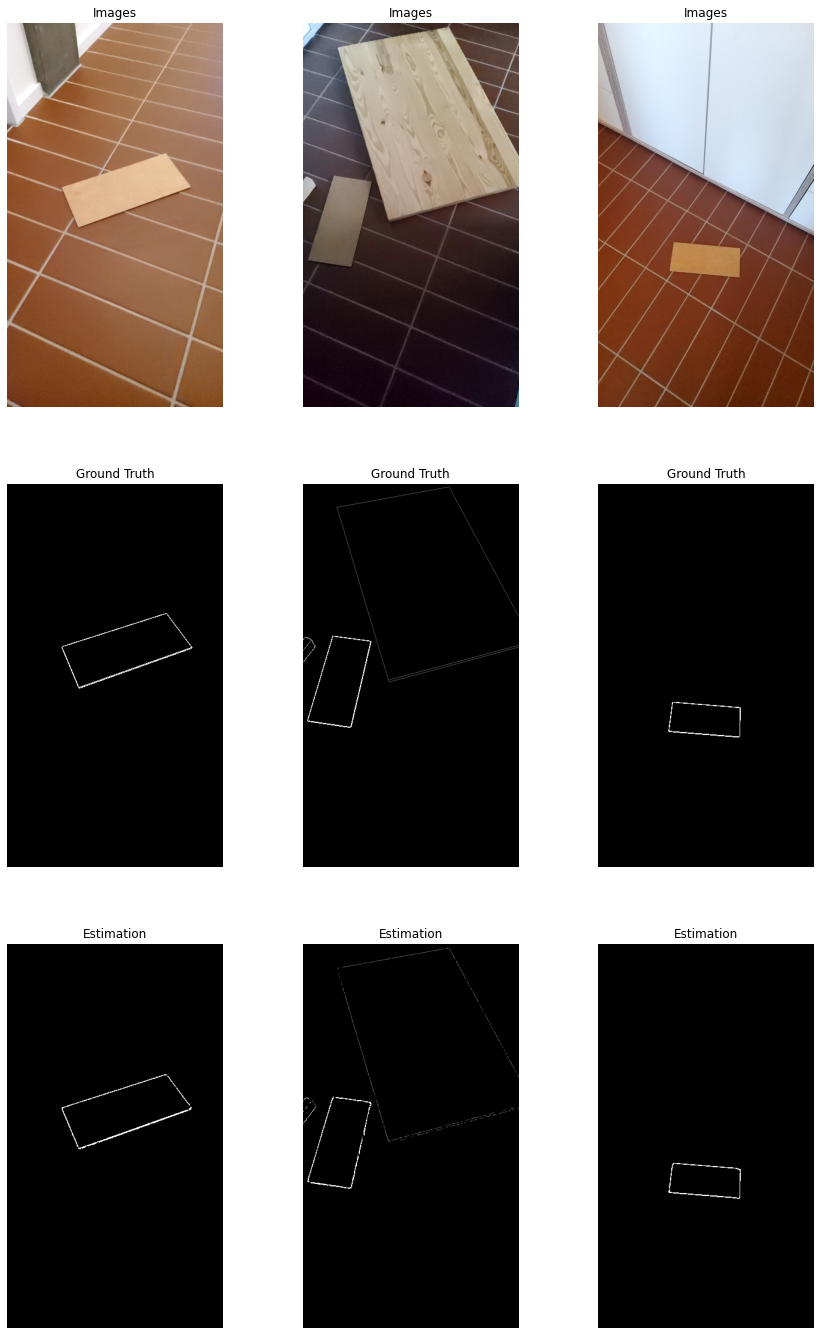

In [11]:
plot_losses = ["loss", "output_loss"]
plot_metrics = ["output_accuracy_edges", "f1", "recall", "precision"]

path = os.path.join(paths["FIGURES"],"training.svg")

visualize.plot_training_results(res=history.history, losses=plot_losses, metrics=plot_metrics, save=SAVE, path=path)


for img, label in train_ds.take(1):
    img, label = img, label

predictions = model.predict(img)    
predictions = visualize.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"training_images_test")
visualize.plot_images(images=img, labels=label, predictions=predictions, save=False, path=path, batch_size=BATCH_SIZE)

# Metric Numerical Results After Fine Tuning on Real World Data

## test

## test hard

# Visual Results After Fine Tuning on Real World Data

## test

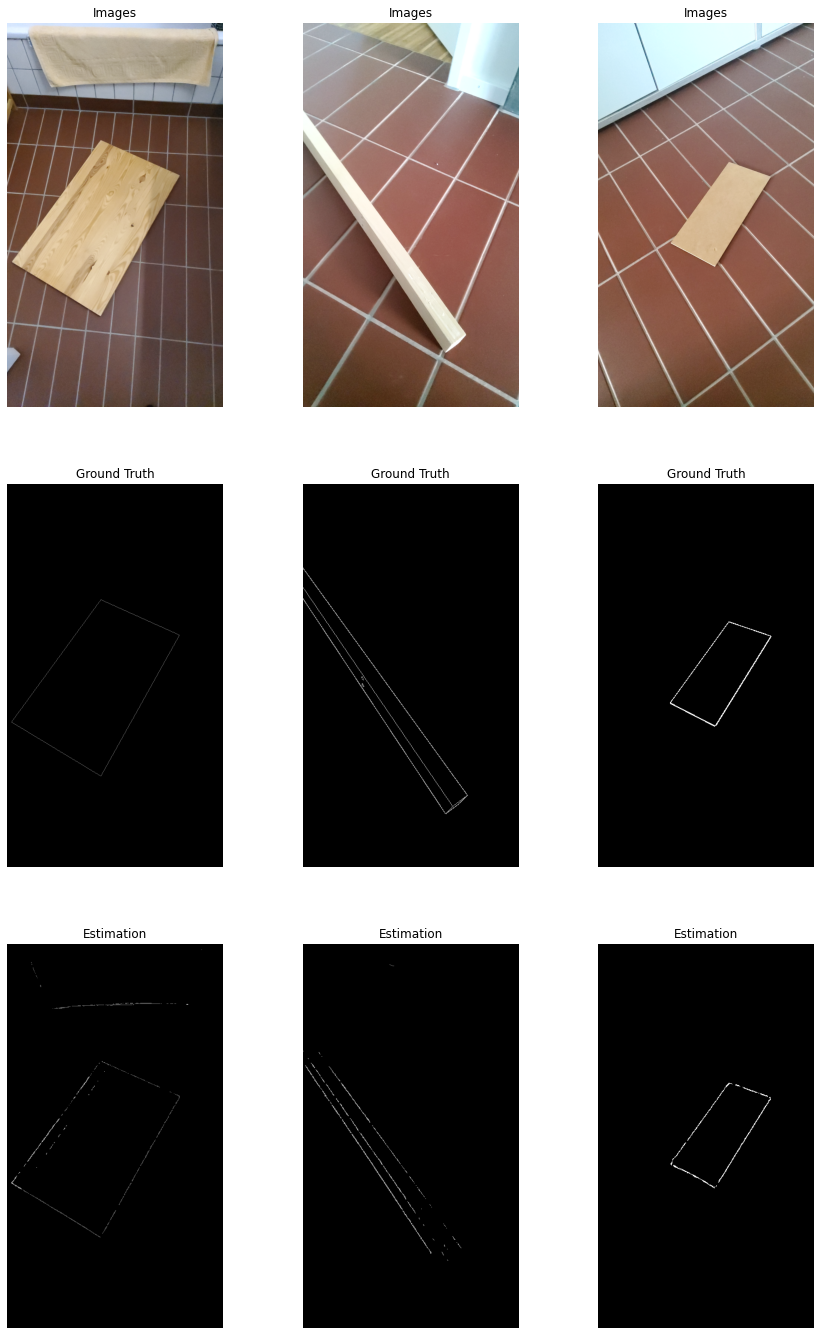

In [12]:
for img, label in test_ds.take(1):
    img, label = img, label

predictions = model.predict(img)    
predictions = visualize.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"post_training_images_test")
visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)

## test hard

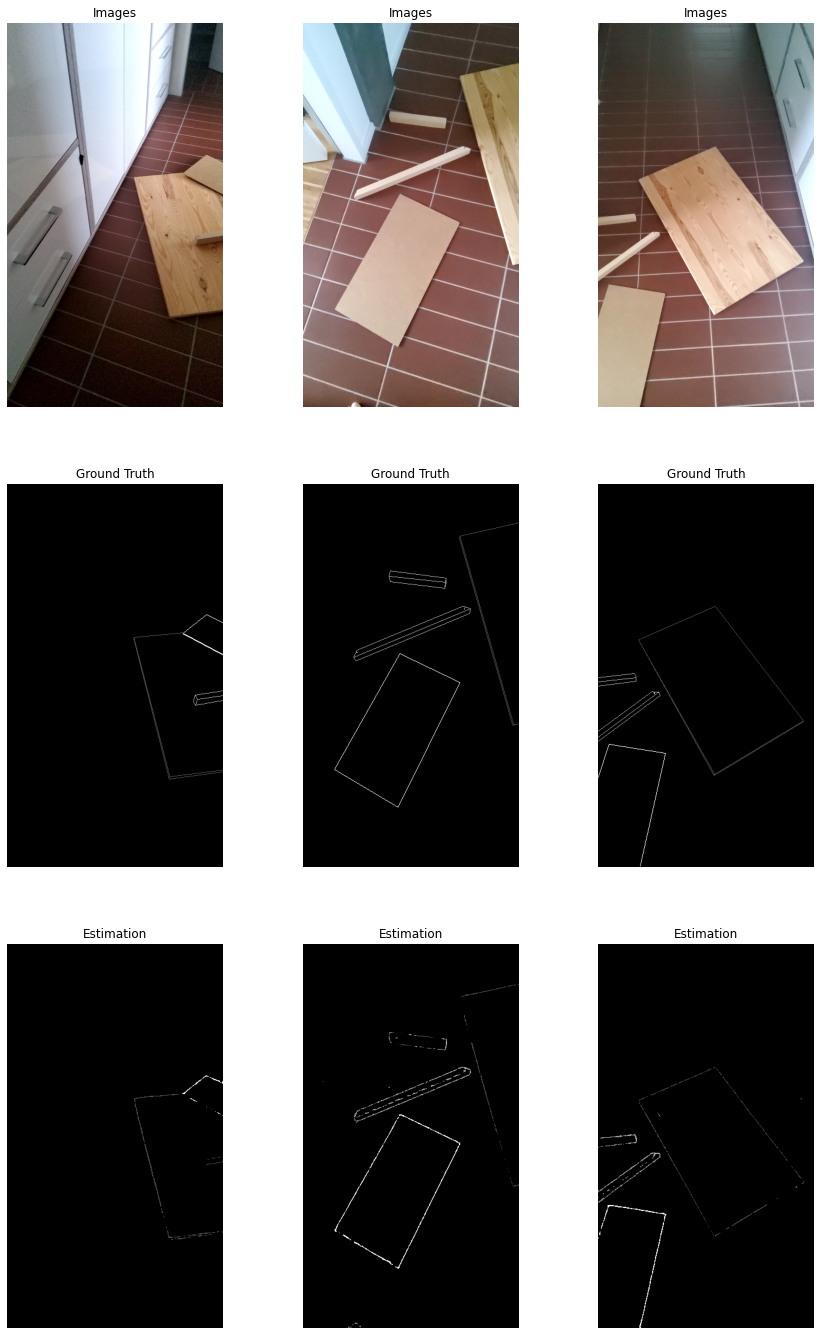

In [13]:
for img, label in test_hard_ds.take(1):
    img, label = img, label

predictions = model.predict(img)    
predictions = visualize.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"post_training_images_test_hard")
visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)

## test img

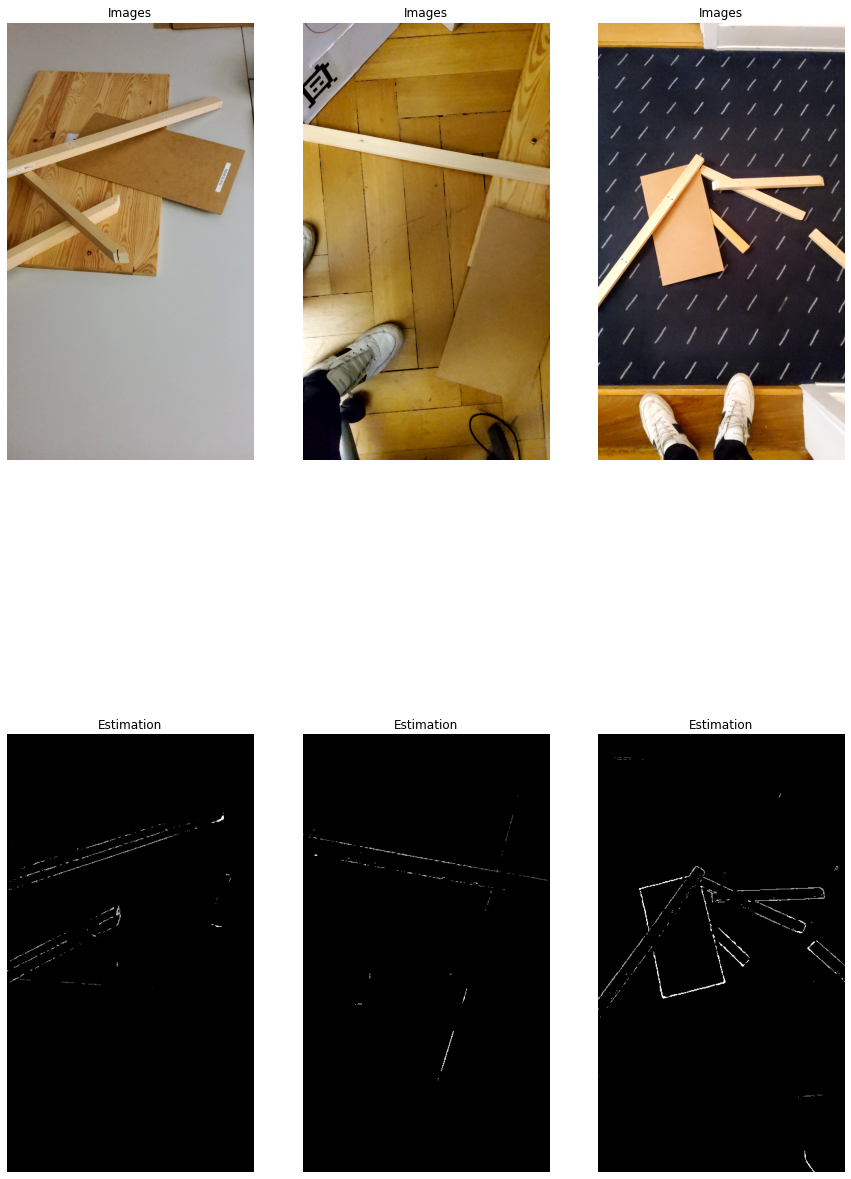

In [14]:
for img in test_img_ds.take(1):
    img = img

predictions = model.predict(img)    
predictions = visualize.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"post_training_images_test_img")

try:
    visualize.plot_images(images=img, labels=None, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)
except:
    visualize.plot_images(images=img, labels=None, predictions=predictions, save=SAVE, path=path, batch_size=img_count_test_img)

# Save Model

In [15]:
if SAVE:
    model.save(paths["MODEL"])
    
    custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges,
                      "F1Edges": metrics.F1Edges,
                      "<lambda>":loss}
    
    model = tf.keras.models.load_model(paths["MODEL"], custom_objects=custom_objects)

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/SceneNetFloorTiledTextureIMG/CASENET_FOCAL_LOSS_0.5_g2_a2_real/assets


# Addtional Elements to Consider in other Projects

* Data augmentation for small datasets